In [ ]:
import docx2txt
import glob
import nltk
import csv

####github.com/michmech
from pt_lematizador import PortugueseMess

In [ ]:
#takes all .docx files in a folder, and writes .txt files with the same content and name as each found.
#the input are the files to be turned into .txt files, an the path to find them, eg. path = r'C:\Documents\Docx_Files\*.docx'
##it is important that the end of the path is *.docx
##it is important that either you make every \ a \\ or add a r before the string
#the output is a .txt file for each .docx file found in the folder


def docx_to_txt(path):
    directory = glob.glob(path)
    for file_name in directory:
        with open(file_name, 'rb') as infile:
            outfile = open(file_name[:-5] + '.txt', 'w', encoding='utf-8')
            doc = docx2txt.process(infile)
            outfile.write(doc)
            infile.close()
            outfile.close()
        

    return "txt files done"

In [ ]:
#takes all .txt files in a folder, and writes all their content in a new file
#the input are the files to be compiled and the path to find them, eg. path = r'C:\Documents\Docx_Files\*.txt'
##it is important that the end of the path is *.txt
##it is important that either you make every \ a \\ or add a r before the string
#the output is a file named 'all_files.txt' with all text in the files found in the folder, separated by a \n

def compile_txt(path):
    directory = glob.glob(path)
    corpus = " "
    
    for file_name in directory:
        with open(file_name, 'r', encoding = 'utf-8') as file:
            corpus += file.read()
        file.close()
        corpus += '\n'
            
    with open('all_files.txt', 'w', encoding = 'utf-8') as newfile:
        newfile.write(corpus)
        newfile.close()
    
    return "compiled txt file done"

In [ ]:
#function that returns a list of strings to be used as stopwords
#the function takes the portuguese stopwords from nltk and adds to it from two .txt files, nomes.txt and outras.txt
#this was done so that the user could easily add to the list of stopwords two different types of words that were reccuring in his project,
#names of people and terms common to the documents that did not bring any useful insights, even though in a different context possibly could,
#thus are not traditionally considered to be stopwords.

def stopwords_fun():
   
    stopwords = nltk.corpus.stopwords.words('portuguese')

    with open("outras.txt","r", encoding = "utf-8") as file:
        outras = file.read()
        file.close()
    stopwords = stopwords + nltk.word_tokenize(outras)

    with open("nomes.txt","r", encoding = "utf-8") as file:
        nomes = file.read()
        file.close()
    stopwords = stopwords + nltk.word_tokenize(nomes)

    return stopwords

In [ ]:
#the function returns a list of strings considered important tokens
#the input is a string (text) and a list of strings (stopwords)
#the function tokenizes the text, removes any token that is not alpha, removes any token found in the stopwords list, and returns the resulting list of strings

def content_tokenize(text, stopwords):
    tokens = nltk.word_tokenize(text)
    tokens_alpha = [w.lower() for w in tokens if w.isalpha()]
    important_tokens = [w for w in tokens_alpha if w not in stopwords and len(w) > 2 and w.isalpha()]
    return important_tokens

In [ ]:
#this function takes a filename for a txt file, and returns its contents as a string
#because this can be used often, making it a function makes the code easier to read

def read_file(filename):   
    with open(filename, 'r', encoding = 'utf-8') as file:
        text = file.read()
        file.close()
    return text

In [ ]:
#this function returns a list of strings with the names of each file in a folder


def filename_list(path):
    directory = glob.glob(path)
    filenames = []
    for filename in directory:
        filenames.append(filename)
    return filenames

In [ ]:
#this function takes a list of tuples and returns a list of tuples
#the output is the same list as the input, but lowering the strings within the tuples and removing any duplicates

def ngram_set_fun(ngram_list):
    ngram_set = []
    for ngram in ngram_list:
        if ngram not in ngram_set:
            ngram_set.append(ngram)
    return ngram_set

In [ ]:
#this function makes a list of tuples containing the ngrams from every file in a path without repetition in each set
#n == 2 means bigrams, n == 3 means trigrams, etc.

def list_sets_fun(path, n = 1):
   list_sets = []
   filenames = filename_list(path)
   for filename in filenames:
      with open(filename, 'r', encoding = 'utf-8') as file:
         #file_ngram_set = ngram_set_fun(list(nltk.ngrams(content_tokenize(file.read(),stopwords_fun()), n)))
         file_ngram_set = ngram_set_fun(nltk.ngrams(nltk.word_tokenize(file.read()), n))
         file.close()
         list_sets.append(list(file_ngram_set[:]))
   
   for set in list_sets:
      if len(set) == 0:
         list_sets.remove(set)
   return list_sets

In [ ]:
#this function takes a list of the tuples found in each set, and the name of the output file as a string
#the result is a coocurrence matrix csv file, separated by ';' instead of the usual ','. that can be changed in line XX of this cell

def cooccurrence_csv(each_set, output_filename):
    complete_set = []
    for set in each_set:
        for token in set:
            if token not in complete_set:
                complete_set.append(token)
    
    cooccurrence = {}

    for ngram in complete_set:
        cooccurrence[ngram] = {}

    for text_ngrams in each_set:
        for ngram in text_ngrams:
            for other_ngram in text_ngrams:
                if ngram != other_ngram:
                    if other_ngram not in cooccurrence[ngram]:
                        cooccurrence[ngram][other_ngram] = 0
                    cooccurrence[ngram][other_ngram] += 1

    with open(output_filename, 'w', newline='',) as csvfile:
        writer = csv.writer(csvfile, delimiter = ';')
        header = [''] + [str(ngram) for ngram in complete_set]
        writer.writerow(header)
        for ngram in complete_set:
            row = [str(ngram)]
            for other_ngram in complete_set:
                count = cooccurrence[ngram].get(other_ngram, 0)
                row.append(count)
            writer.writerow(row)
        csvfile.close()

    return "coocurrence file done"

In [ ]:
#this function has the purpose of looking for ngrams that start with any term in a given list of terms
#the input is two lists of strings and an int value n, that determines the lenght of the ngram
#the output is a list of strings
#the search is not case sensitive


def search_ngrams(token_list, search_term_list, n = 1):
    search_results = []
    ngrams = list(nltk.ngrams(token_list, n))
    for term in search_term_list:
        for ngram in ngrams:
            if term.lower() == ngram[0].lower():
                search_results.append(ngram)
    
    return search_results

In [ ]:
#this function takes a list of tuples of strings, and returns a .txt file containing its contents
#the strings are separated by spaces, and the tuples by lines
#example of output_filename: 'friends_list.txt'

def tuple_list_to_txt(tuple_list, output_filename):
    file_content = ''
    for tup in tuple_list:
        for word in tup:
            file_content += word
            file_content += ' '
        file_content += ('\n')

    with open(output_filename, 'w', encoding = 'utf-8') as file:
        file.write(file_content)
        file.close()

    return "txt file done"

In [ ]:
#this function makes a unigram tagger that, when meeting an unknown word, assumes it is a noun
#this was done because usually it would fail to identify proper nouns
#takes no parameters
#should be saved in a variable, like so: tagger = tagger_maker()
#and used like so: tagged_tokens_list = tagger.tag(untagged_token_list)
#this procedure results in a list of tuples that looks like this: [('token1', 'N')]

def tagger_maker():
    train = nltk.corpus.mac_morpho.tagged_sents()
    tagger = nltk.tag.UnigramTagger(train, backoff = nltk.tag.DefaultTagger('N'))
    return tagger

In [ ]:
#this function makes a list of tuples with the token and it's tag
#its parameters are the list of strings of tokens the user wants to tag, and a nltk.tag.sequential.UnigramTagger
#by default, the tagger will be the one obtained from the function tagger_maker()

def token_tagger(token_list, tagger = tagger_maker()):
    return tagger.tag(token_list)

...

In [ ]:
#this function asks the user to type .txt or .docx, and returns a string containing the anwser

def interface_type_input(type_options = ['.txt', '.docx']):
    type_input = str(input('Digite o tipo dos arquivos a serem analisados (.txt ou .docx):\n')).lower().strip()
    if type_input[0] != '.':
        type_input = '.' + type_input
    if type_input not in type_options:
        print('O arquivo deve ser do tipo .txt ou .docx. Certifique-se de que o valor digitado está correto.\n')
        return interface_type_input(type_options)
    return type_input

In [ ]:
#this function asks the user for the path of the files in the computer
#to avoid bugs and errors, every \ and every / is replaced by \\
#returns a string with the path

def interface_path_input():
    path_input = str(input('Digite o caminho para a pasta onde se encontram os arquivos (exemplo: C:\Documents\Analise\Arquivos\):\n'))
    if '\\\\' not in path_input:
        if '/'in path_input:
            path_input = path_input.replace('/', '\\')
        path_input = path_input.replace('\\', '\\\\')
    if path_input[-1] != '\\':
        path_input += '\\\\'
    return path_input

In [ ]:
#this function asks the user what functions they would like to use through yes or no questions
#returns a list of subslists containg a string with the question asked and a bool var with anwser given

def interface_user_picks():
    print('''Decida quais operações o programa deve realizar:\n
          Caso se arrependa de qualquer decisão realizada, digite "Recomeçar".\n
          Responda as perguntas digitando "Sim" ou "Não".\n\n''')
    positive_terms = ['sim', 's', 'si', 'im', 'yes', 'y']
    negative_terms = ['não', 'nao', 'nã', 'na','ão', 'ao', 'no', 'n']
    decisions = [['''Remover Stopwords?\n
                  (Stopwords do pacote nltk, termos não alfabéticos, termos com menos que duas letras e aqueles encontradas nos arquivos nomes.txt e outras.txt)\n'''],
                 ['Tornar tokens stems? (Não recomendado caso deseje utilizar a função search_ngrams)\n'],
                 ['''Deseja utilizar a função search_ngrams?\n
                  (O usuário define um ou mais termos a serem buscados, e serão exibidas as ocorrências desses termos com os tokens
                  encontrados em sequência, facilitando leitura do contexto onde os termos escolhidos se inserem).\n'''],
                  ['Deseja gerar um arquivo csv de coocorrência de tokens/ngrams? (Verifica quais tokens ou ngrams aparecem conjuntamente nos arquivos)\n'],
                  ['Deseja visualizar os tokens/ngrams mais frequentes?\n']]


    for index in range(len(decisions)):
        question = decisions[index][0]
        anwser = input(decisions[index][0]).lower().strip()

        if anwser not in positive_terms and anwser not in negative_terms:
            return interface_user_picks()
        if anwser in positive_terms:
            decisions[index].append(True)
        else:
            decisions[index].append(False)
    print('Fim decisões.\n\n')
    return decisions

In [ ]:
#this function asks what words the user would like to search within the list_of_tokens, and how many tokens after
#returns a list of the sublist containing each term searched, the result from calling the function search_ngrams with the given parameters

def interface_user_searches(list_of_tokens):
    tokens_after_term = int(input('Digite, em algarismos, quantas palavras deseja visualizar após cada termo buscado que for encontrado:\n')) + 1
    print('''Digite os termos que deseja buscar, pressionando Enter depois de cada um. Quando terminar, digite 000.''')
    list_of_terms = []
    term = ''
    while term != '000':
        term = str(input()).strip()
        list_of_terms.append(term.lower())

    return [list_of_terms[:-1], search_ngrams(list_of_tokens, list_of_terms, tokens_after_term)]

In [ ]:
#this function asks the user how many of the most common bigrams in the list_of_tokens they would like to see, and the value n
#returns a list with the resulting FreqDist, and the amount choosen

def interface_freqdist(list_of_tokens):
    amount = int(input('''Digite, em algarismos, o número de ngrams mais frequentes a serem visualizados: '''))
    n = int(input('Digite, em algarismos, o valor n dos ngrams a serem observados (1 para tokens, 2 para bigrams, 3 para trigrams, etc): '))
    
    return [nltk.FreqDist(nltk.ngrams(list_of_tokens, n)), amount]

In [ ]:
#this function facilitates the use of the cooccurence_csv function
#its parameters are the path to the files as a string, and a bool stating wheter to remove stopwords or not
#then, the function asks the user for the value n of the ngrams, and the name of the file to be generated
#then the function calls for cooccurrence_csv with the given filename and the list of sets, with or without stopwords and non alphabetic values, depending on bool_stopwords

def interface_coocurrence(path, bool_stopwords):
    n_input = int(input(
        '''Digite, em algarismo, o valor n do ngram que se deseja observar a coocorrência.\n
        (1 para token, 2 para bigrama, 3 para trigrama, etc.)\n
        (Quanto maior esse valor, mais lento será a geração do arquivo e maior será seu tamanho) '''))
    

    filename = input('Digite o nome do arquivo a ser gerado: ')
    if filename[-4:] != '.csv':
        filename += '.csv'
    


    if bool_stopwords:
        remove_ngram = False
        stopwords = stopwords_fun()
        complete_set = list_sets_fun(path, n_input)
        every_set = []
        for set in complete_set:
            every_set.append([])
        #each set
        for i in range(len(complete_set)):
            #each ngram
            for j in range(len(complete_set[i])):
                append_ngram = True
                for token in complete_set[i][j]:
                    if token in stopwords or token.isalpha() == False:
                        append_ngram = False
                if append_ngram == True:
                    every_set[i].append(complete_set[i][j])

    else:
        every_set = list_sets_fun(path, n_input)
    

    return cooccurrence_csv(every_set, filename)

In [ ]:
#this function calls the interface_ functions, and runs them according to the anwsers given by the user in interface_user_picks

def interface():
    print('''Orientações:
          \nOs arquivos a serem analisados devem ser todos do mesmo tipo, .docx ou .txt.
          \nDevem todos se encontrar em uma mesma pasta em seu diretório.
          \nSerão analisados todos os arquivos da pasta indicada.
          \n\nAVISOS:
          \nRodar esse programa irá gerar um arquivo denominado all_files.txt.
          \nRodar esse programa para ler arquivos .docx irá gerar arquivos .txt que levam o mesmo nome que seus equivalentes em .docx
          \nCaso seja encontrado arquivo com nome idêntico a um a ser gerado, o arquivo antigo será substituido.
          \nRecomenda-se que o programa seja utilizado por um usuário com conhecimentos de Python, e que o script seja adaptado para as
necessidades específicas do usuário.
          \n\n
          ''')
    
    type_input = interface_type_input()
    path_input = interface_path_input()

    path = path_input + '*' + type_input
    if type_input == '.docx':
        docx_to_txt(path)
    path = path_input + '*.txt'
    
    compile_txt(path)
    all_text = read_file('all_files.txt')
    all_tokens = nltk.word_tokenize(all_text)

    user_picks = interface_user_picks()

    #remove stopwords
    if user_picks[0][1] == True:
        all_content = content_tokenize(all_text, stopwords_fun())
    else: 
        all_content = [word.lower() for word in all_tokens]
    
    #stem tokens
    if user_picks[1][1] == True:
        #for portuguese:
        all_lemmas = [PortugueseMess(word) for word in all_content]
        all_content = all_lemmas

        #for english:
        ##stemmer = nltk.stem.WordNetLemmatizer()
        ##all_lemmas = [stemmer.lemmatize(word) for word in all_content]
        ##all_content = all_lemmas

    #coocurrence_csv
    if user_picks[3][1] == True:
        interface_coocurrence(path, user_picks[0][1])

    #ngram_search
    if user_picks[2][1] == True:
        search_result = interface_user_searches(all_content)
        print('\nTermos buscados:')
        for term in search_result[0]:
            print('\t- "', term, '"', sep = '')
        print('\nFrases encontradas:')
        for result in search_result[1]:
            print('\t- "', result, '"', sep = '')
           
    #view freqdist graph of ngrams
    if user_picks[4][1] == True:
        ngram_freqdist = interface_freqdist(all_content)
        print('\nGráfico dos ngrams mais frequentes:')
        ngram_freqdist[0].plot(ngram_freqdist[1], cumulative = True)

Orientações:
          
Os arquivos a serem analisados devem ser todos do mesmo tipo, .docx ou .txt.
          
Devem todos se encontrar em uma mesma pasta em seu diretório.
          
Serão analisados todos os arquivos da pasta indicada.
          

AVISOS:
          
Rodar esse programa irá gerar um arquivo denominado all_files.txt.
          
Rodar esse programa para ler arquivos .docx irá gerar arquivos .txt que levam o mesmo nome que seus equivalentes em .docx
          
Caso seja encontrado arquivo com nome idêntico a um a ser gerado, o arquivo antigo será substituido.
          
Recomenda-se que o programa seja utilizado por um usuário com conhecimentos de Python, e que o script seja adaptado para as
necessidades específicas do usuário.
          


          
Decida quais operações o programa deve realizar:

          Caso se arrependa de qualquer decisão realizada, digite "Recomeçar".

          Responda as perguntas digitando "Sim" ou "Não".


Fim decisões.



Gráfico dos ngr

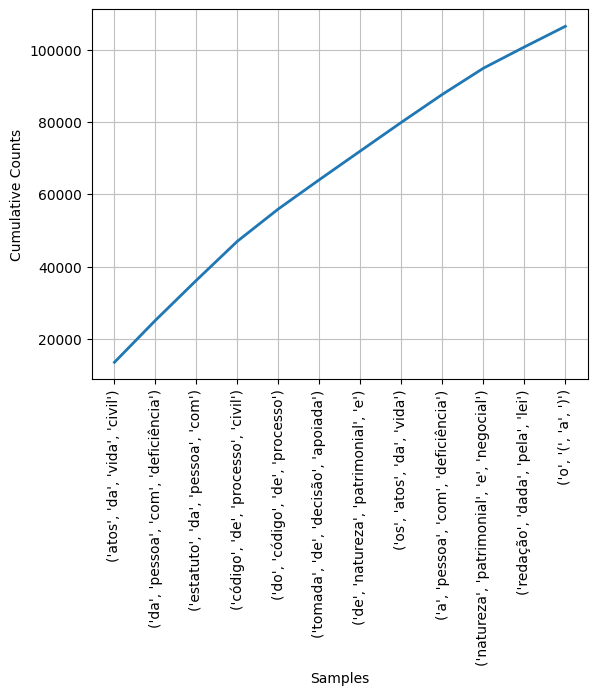

In [25]:
if __name__ == '__main__':
    interface()